# Final Project

### Setup

In [6]:
import sys
from importlib import reload

import nose
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
%matplotlib inline

from collections import defaultdict, Counter
from src import constants, preproc, most_common, clf_base, evaluation
from src import scorer, tagger_base, naive_bayes, hmm, viterbi, bilstm
from src.constants import OFFSET

### Preprocessing
All data are from [universal dependencies website](http://universaldependencies.org/en/pos/index.html).

In [62]:
# Load data
EN_TRAIN_FILE = constants.TRAIN_FILE
EN_DEV_FILE = constants.DEV_FILE
EN_TEST_FILE = constants.TEST_FILE

GK_TRAIN_FILE = constants.GK_TRAIN_FILE
GK_DEV_FILE = constants.GK_DEV_FILE
GK_TEST_FILE = constants.GK_TEST_FILE

KR_TRAIN_FILE = constants.KR_TRAIN_FILE
KR_DEV_FILE = constants.KR_DEV_FILE
KR_TEST_FILE = constants.KR_TEST_FILE

SW_TRAIN_FILE = constants.SW_TRAIN_FILE
SW_DEV_FILE = constants.SW_DEV_FILE
SW_TEST_FILE = constants.SW_TEST_FILE

In [4]:
# Tags
all_tags = set([])
for (words, tags) in preproc.conll_seq_generator(EN_TRAIN_FILE):
    for tag in tags:
        all_tags.add(tag)
all_tags = sorted(all_tags)
print(all_tags)

['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']


### Example Taggers (provided from CSE 447)

In [191]:
# Classifies all as noun
classifier_noun_tagger = tagger_base.make_classifier_tagger(most_common.get_noun_weights())
confusion = tagger_base.eval_tagger(classifier_noun_tagger, 'all-nouns.preds', all_tags=all_tags)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_tagger(classifier_noun_tagger, 'all-nouns.preds', all_tags=all_tags, testfile=EN_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_tagger(classifier_noun_tagger, 'all-nouns.preds', all_tags=all_tags, testfile=EN_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Accuracy:
 Dev:    0.1527613022274944 
 Train:  0.16539369880910507 
 Test:   0.1744174516608825


In [193]:
# Classifies as their most common tag
theta_mc = most_common.get_most_common_word_weights(EN_TRAIN_FILE)
tagger_mc = tagger_base.make_classifier_tagger(theta_mc)
confusion = tagger_base.eval_tagger(tagger_mc, 'most-common.preds', all_tags=all_tags)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_tagger(tagger_mc, 'most-common.preds', all_tags=all_tags, testfile=EN_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_tagger(tagger_mc, 'most-common.preds', all_tags=all_tags, testfile=EN_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Accuracy:
 Dev:    0.8111242915513378 
 Train:  0.9283955580121602 
 Test:   0.7340109072880515


In [194]:
# Classifies using Naive Bayes
nb_weights = naive_bayes.get_nb_weights(EN_TRAIN_FILE, .01)
vocab = set([word for tag,word in nb_weights.keys() if word is not constants.OFFSET])
confusion = tagger_base.eval_tagger(tagger_base.make_classifier_tagger(nb_weights), 'nb-simple.preds')
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_tagger(tagger_base.make_classifier_tagger(nb_weights), 'nb-simple.preds', testfile=EN_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_tagger(tagger_base.make_classifier_tagger(nb_weights), 'nb-simple.preds', testfile=EN_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print(dev_acc)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

0.8104652695400026
Accuracy:
 Dev:    0.8104652695400026 
 Train:  0.9283704336465505 
 Test:   0.731631135349529


### HMM Model Training

In [39]:
START_TAG = constants.START_TAG
END_TAG = constants.END_TAG
UNK = constants.UNK

In [187]:
# Train on English corpus
tag_trans_counts = most_common.get_tag_trans_counts(EN_TRAIN_FILE)
hmm_trans_weights = hmm.compute_transition_weights(tag_trans_counts, .001)
all_tags = sorted(list(tag_trans_counts.keys()) + [END_TAG])
nb_weights = naive_bayes.get_nb_weights(EN_TRAIN_FILE, .01)
vocab, word_to_ix = most_common.get_word_to_ix(EN_TRAIN_FILE)

tag_to_ix = {}
for tag in list(all_tags):
    if tag not in tag_to_ix:
        tag_to_ix[tag]=len(tag_to_ix)

emission_probs, tag_transition_probs = hmm.compute_weights_variables(nb_weights, hmm_trans_weights, vocab, word_to_ix, tag_to_ix)

tagger = lambda words, all_tags : viterbi.build_trellis(all_tags, 
                                                        tag_to_ix,
                                                        [emission_probs[word_to_ix[w]] 
                                                         if w in word_to_ix 
                                                         else emission_probs[word_to_ix[UNK]] 
                                                         for w in words],
                                                        tag_transition_probs)[1]

# Test the model
confusion = tagger_base.eval_tagger(tagger, 'hmm-dev-en.preds', all_tags)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_tagger(tagger, 'hmm-train-en.preds', all_tags, testfile=EN_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_tagger(tagger, 'hmm-test-en.preds', all_tags, testfile=EN_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Accuracy:
 Dev:    0.8409120864636879 
 Train:  0.9621627053916889 
 Test:   0.7676747645017352


In [188]:
# Train on Greek corpus
tag_trans_counts_gk = most_common.get_tag_trans_counts(GK_TRAIN_FILE)
hmm_trans_weights_gk = hmm.compute_transition_weights(tag_trans_counts_gk, .001)
all_tags_gk = sorted(list(tag_trans_counts_gk.keys()) + [END_TAG])
nb_weights_gk = naive_bayes.get_nb_weights(GK_TRAIN_FILE, .01)
vocab_gk, word_to_ix_gk = most_common.get_word_to_ix(GK_TRAIN_FILE)

tag_to_ix_gk = {}
for tag in list(all_tags_gk):
    if tag not in tag_to_ix_gk:
        tag_to_ix_gk[tag]=len(tag_to_ix_gk)

emission_probs_gk, tag_transition_probs_gk = hmm.compute_weights_variables(nb_weights_gk, hmm_trans_weights_gk, vocab_gk, word_to_ix_gk, tag_to_ix_gk)

tagger = lambda words, all_tags : viterbi.build_trellis(all_tags_gk, 
                                                        tag_to_ix_gk,
                                                        [emission_probs_gk[word_to_ix_gk[w]] 
                                                         if w in word_to_ix_gk
                                                         else emission_probs_gk[word_to_ix_gk[UNK]] 
                                                         for w in words],
                                                        tag_transition_probs_gk)[1]

# Test the model
confusion = tagger_base.eval_tagger(tagger, 'hmm-dev-gk.preds', all_tags_gk, trainfile=GK_TRAIN_FILE, testfile=GK_DEV_FILE)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_tagger(tagger, 'hmm-train-gk.preds', all_tags_gk, trainfile=GK_TRAIN_FILE, testfile=GK_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_tagger(tagger, 'hmm-test-gk.preds', all_tags_gk, trainfile=GK_TRAIN_FILE, testfile=GK_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Accuracy:
 Dev:    0.9022121300908292 
 Train:  0.9653644009345944 
 Test:   0.9069400630914827


In [189]:
# Train on Korean corpus
tag_trans_counts_kr = most_common.get_tag_trans_counts(KR_TRAIN_FILE)
hmm_trans_weights_kr = hmm.compute_transition_weights(tag_trans_counts_kr, .001)
all_tags_kr = sorted(list(tag_trans_counts_kr.keys()) + [END_TAG])
nb_weights_kr = naive_bayes.get_nb_weights(KR_TRAIN_FILE, .01)
vocab_kr, word_to_ix_kr = most_common.get_word_to_ix(KR_TRAIN_FILE)

tag_to_ix_kr = {}
for tag in list(all_tags_kr):
    if tag not in tag_to_ix_kr:
        tag_to_ix_kr[tag]=len(tag_to_ix_kr)

emission_probs_kr, tag_transition_probs_kr = hmm.compute_weights_variables(nb_weights_kr, hmm_trans_weights_kr, vocab_kr, word_to_ix_kr, tag_to_ix_kr)

tagger = lambda words, all_tags : viterbi.build_trellis(all_tags_kr, 
                                                        tag_to_ix_kr,
                                                        [emission_probs_kr[word_to_ix_kr[w]] 
                                                         if w in word_to_ix_kr
                                                         else emission_probs_kr[word_to_ix_kr[UNK]] 
                                                         for w in words],
                                                        tag_transition_probs_kr)[1]

# Test the model
confusion = tagger_base.eval_tagger(tagger, 'hmm-dev-kr.preds', all_tags_kr, trainfile=KR_TRAIN_FILE, testfile=KR_DEV_FILE)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_tagger(tagger, 'hmm-train-kr.preds', all_tags_kr, trainfile=KR_TRAIN_FILE, testfile=KR_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_tagger(tagger, 'hmm-test-kr.preds', all_tags_kr, trainfile=KR_TRAIN_FILE, testfile=KR_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Accuracy:
 Dev:    0.814621409921671 
 Train:  0.9699135761656423 
 Test:   0.8106535993795388


In [190]:
# Train on Swedish Sign Language corpus
tag_trans_counts_sw = most_common.get_tag_trans_counts(SW_TRAIN_FILE)
hmm_trans_weights_sw = hmm.compute_transition_weights(tag_trans_counts_sw, .001)
all_tags_sw = sorted(list(tag_trans_counts_sw.keys()) + [END_TAG])
nb_weights_sw = naive_bayes.get_nb_weights(SW_TRAIN_FILE, .01)
vocab_sw, word_to_ix_sw = most_common.get_word_to_ix(SW_TRAIN_FILE)

tag_to_ix_sw = {}
for tag in list(all_tags_sw):
    if tag not in tag_to_ix_sw:
        tag_to_ix_sw[tag]=len(tag_to_ix_sw)

emission_probs_sw, tag_transition_probs_sw = hmm.compute_weights_variables(nb_weights_sw, hmm_trans_weights_sw, vocab_sw, word_to_ix_sw, tag_to_ix_sw)

tagger = lambda words, all_tags : viterbi.build_trellis(all_tags_sw, 
                                                        tag_to_ix_sw,
                                                        [emission_probs_sw[word_to_ix_sw[w]] 
                                                         if w in word_to_ix_sw
                                                         else emission_probs_sw[word_to_ix_sw[UNK]] 
                                                         for w in words],
                                                        tag_transition_probs_sw)[1]

# Test the model
confusion = tagger_base.eval_tagger(tagger, 'hmm-dev-sw.preds', all_tags_sw, trainfile=SW_TRAIN_FILE, testfile=SW_DEV_FILE)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_tagger(tagger, 'hmm-train-sw.preds', all_tags_sw, trainfile=SW_TRAIN_FILE, testfile=SW_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_tagger(tagger, 'hmm-test-sw.preds', all_tags_sw, trainfile=SW_TRAIN_FILE, testfile=SW_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Accuracy:
 Dev:    0.6418128654970761 
 Train:  0.9891304347826086 
 Test:   0.75177304964539


Drop in accuracy for Korean and Swedish Sign Language (SSL) corpus is expected, becase Greek and English are from the same linguistic family but the rest are not. SSL corpus is expected to have lower accuracy as the size of data is significantly smaller than the rest.

### GRU Model Training

Epoch 1: Dev Accuracy: 0.8166600764465534
Epoch 2: Dev Accuracy: 0.8430209568999605
Epoch 3: Dev Accuracy: 0.8589692895742718
Epoch 4: Dev Accuracy: 0.85593778832213
Epoch 5: Dev Accuracy: 0.8618689864241466
Epoch 6: Dev Accuracy: 0.863318834849084
Epoch 7: Dev Accuracy: 0.8500065902201134
Epoch 8: Dev Accuracy: 0.8608145512060102
Epoch 9: Dev Accuracy: 0.856201397126664
Epoch 10: Dev Accuracy: 0.8573876367470673
Accuracy:
 Dev:    0.8573876367470673 
 Train:  0.9862067232802372 
 Test:   0.7436291522062469


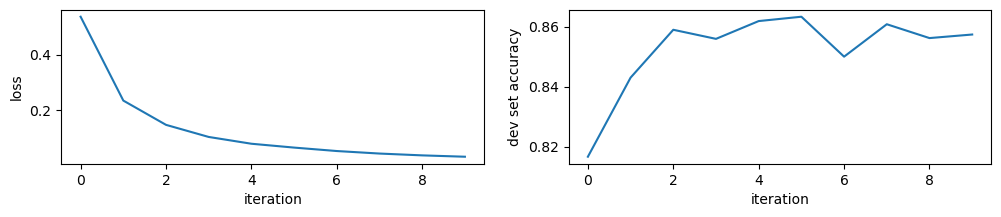

In [163]:
# Set hyperparameters and variables
vocab, word_to_ix = most_common.get_word_to_ix(EN_TRAIN_FILE, 6900)
X_tr, Y_tr = preproc.load_data(EN_TRAIN_FILE)
X_dv, Y_dv = preproc.load_data(EN_DEV_FILE)
X_te, Y_te = preproc.load_data(EN_TEST_FILE)

if START_TAG in all_tags:
    all_tags.remove(START_TAG)
if END_TAG in all_tags:
    all_tags.remove(END_TAG)
tag_to_ix = {}
for tag in all_tags:
    if tag not in tag_to_ix:
        tag_to_ix[tag] = len(tag_to_ix)

filename = 'data/polyglot-en.pkl'
word_embeddings = bilstm.obtain_polyglot_embeddings(filename, word_to_ix)
torch.manual_seed(711)
embedding_dim = 64
hidden_dim = 30
model = bilstm.GRU(len(word_to_ix), tag_to_ix, embedding_dim, hidden_dim, word_embeddings)

# Train on English corpus
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr, Y_tr, word_to_ix, tag_to_ix, 
                                        X_dv, Y_dv, num_its=10, status_frequency=1,
                                        optim_args = {'lr':0.1,'momentum':0.5}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model, 'gru-dev-en.preds', word_to_ix)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'gru-train-en.preds', word_to_ix, all_tags, testfile=EN_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'gru-test-en.preds', word_to_ix, all_tags, testfile=EN_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Epoch 1: Dev Accuracy: 0.6664957515382361
Epoch 2: Dev Accuracy: 0.7505859947260475
Epoch 3: Dev Accuracy: 0.759888661002051
Epoch 4: Dev Accuracy: 0.7825959566363903
Epoch 5: Dev Accuracy: 0.7892616466451802
Epoch 6: Dev Accuracy: 0.7987840609434516
Epoch 7: Dev Accuracy: 0.8006152944623498
Epoch 8: Dev Accuracy: 0.8036185174333431
Epoch 9: Dev Accuracy: 0.810284207442133
Epoch 10: Dev Accuracy: 0.8126281863463228
Accuracy:
 Dev:    0.8126281863463228 
 Train:  0.8456315195714126 
 Test:   0.8102748986029743


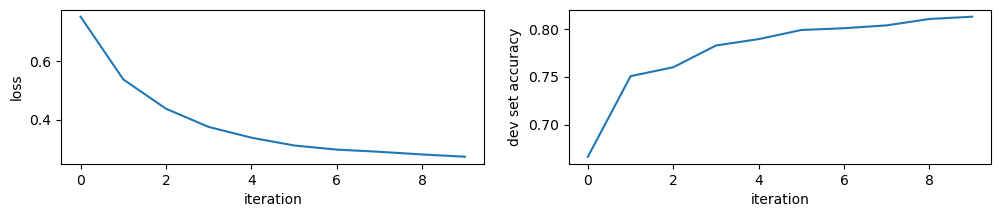

In [164]:
# Set hyperparameters and variables
vocab_gk, word_to_ix_gk = most_common.get_word_to_ix(GK_TRAIN_FILE, 6900)
X_tr_gk, Y_tr_gk = preproc.load_data(GK_TRAIN_FILE)
X_dv_gk, Y_dv_gk = preproc.load_data(GK_DEV_FILE)
X_te_gk, Y_te_gk = preproc.load_data(GK_TEST_FILE)

if START_TAG in all_tags_gk:
    all_tags_gk.remove(START_TAG)
if END_TAG in all_tags_gk:
    all_tags_gk.remove(END_TAG)
tag_to_ix_gk = {}
for tag in all_tags_gk:
    if tag not in tag_to_ix_gk:
        tag_to_ix_gk[tag] = len(tag_to_ix_gk)

torch.manual_seed(711)
embedding_dim = 64 #30
hidden_dim = 30
model = bilstm.GRU(len(word_to_ix_gk), tag_to_ix_gk, embedding_dim, hidden_dim)

# Train on Greek corpus
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr_gk, Y_tr_gk, word_to_ix_gk, tag_to_ix_gk, 
                                        X_dv_gk, Y_dv_gk, num_its=10, status_frequency=1,
                                        optim_args = {'lr':0.1,'momentum':0.5}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model, 'gru-dev-gk.preds', word_to_ix_gk, trainfile=GK_TRAIN_FILE, testfile=GK_DEV_FILE)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'gru-train-gk.preds', word_to_ix_gk, all_tags_gk, trainfile=GK_TRAIN_FILE, testfile=GK_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'gru-test-gk.preds', word_to_ix_gk, all_tags_gk, trainfile=GK_TRAIN_FILE, testfile=GK_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Epoch 1: Dev Accuracy: 0.6606139726244165
Epoch 2: Dev Accuracy: 0.6980378194477411
Epoch 3: Dev Accuracy: 0.7230793575441095
Epoch 4: Dev Accuracy: 0.7339188226916686
Epoch 5: Dev Accuracy: 0.7428989635255954
Epoch 6: Dev Accuracy: 0.7429385236173748
Epoch 7: Dev Accuracy: 0.7448374080227866
Epoch 8: Dev Accuracy: 0.7476066144473456
Epoch 9: Dev Accuracy: 0.7493472584856397
Epoch 10: Dev Accuracy: 0.7512461428910515
Accuracy:
 Dev:    0.7512461428910515 
 Train:  0.776212193789088 
 Test:   0.74113375167454


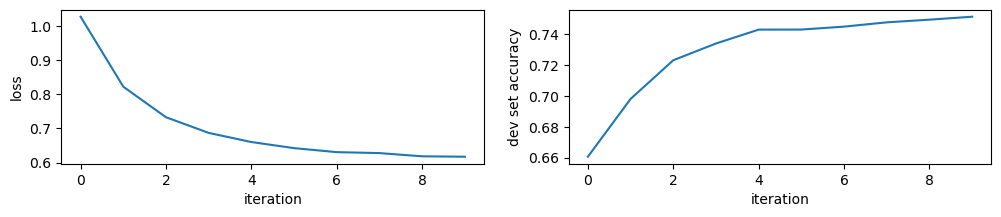

In [165]:
# Set hyperparameters and variables
vocab_kr, word_to_ix_kr = most_common.get_word_to_ix(KR_TRAIN_FILE, 6900)
X_tr_kr, Y_tr_kr = preproc.load_data(KR_TRAIN_FILE)
X_dv_kr, Y_dv_kr = preproc.load_data(KR_DEV_FILE)
X_te_kr, Y_te_kr = preproc.load_data(KR_TEST_FILE)

if START_TAG in all_tags_kr:
    all_tags_kr.remove(START_TAG)
if END_TAG in all_tags_kr:
    all_tags_kr.remove(END_TAG)
tag_to_ix_kr = {}
for tag in all_tags_kr:
    if tag not in tag_to_ix_kr:
        tag_to_ix_kr[tag] = len(tag_to_ix_kr)

torch.manual_seed(711)
embedding_dim = 64 #30
hidden_dim = 30
model = bilstm.GRU(len(word_to_ix_kr), tag_to_ix_kr, embedding_dim, hidden_dim)

# Train on Korean corpus
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr_kr, Y_tr_kr, word_to_ix_kr, tag_to_ix_kr, 
                                        X_dv_kr, Y_dv_kr, num_its=10, status_frequency=1,
                                        optim_args = {'lr':0.1,'momentum':0.5}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model, 'gru-dev-kr.preds', word_to_ix_kr, trainfile=KR_TRAIN_FILE, testfile=KR_DEV_FILE)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'gru-train-kr.preds', word_to_ix_kr, all_tags_kr, trainfile=KR_TRAIN_FILE, testfile=KR_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'gru-test-kr.preds', word_to_ix_kr, all_tags_kr, trainfile=KR_TRAIN_FILE, testfile=KR_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Epoch 1: Dev Accuracy: 0.3786549707602339
Epoch 2: Dev Accuracy: 0.46637426900584794
Epoch 3: Dev Accuracy: 0.5043859649122807
Epoch 4: Dev Accuracy: 0.5263157894736842
Epoch 5: Dev Accuracy: 0.5555555555555556
Epoch 6: Dev Accuracy: 0.5584795321637427
Epoch 7: Dev Accuracy: 0.5716374269005848
Epoch 8: Dev Accuracy: 0.5745614035087719
Epoch 9: Dev Accuracy: 0.5745614035087719
Epoch 10: Dev Accuracy: 0.5745614035087719
Accuracy:
 Dev:    0.5745614035087719 
 Train:  0.9922360248447205 
 Test:   0.5638297872340425


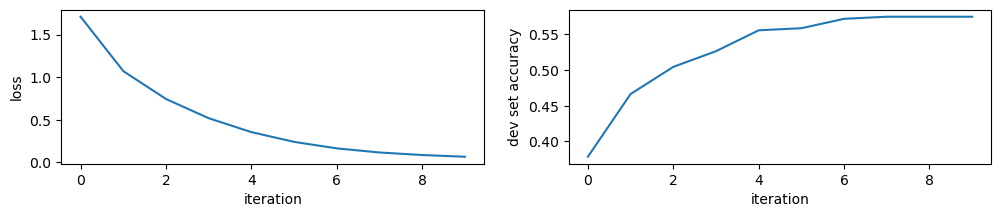

In [166]:
# Set hyperparameters and variables
vocab_sw, word_to_ix_sw = most_common.get_word_to_ix(SW_TRAIN_FILE, 6900)
X_tr_sw, Y_tr_sw = preproc.load_data(SW_TRAIN_FILE)
X_dv_sw, Y_dv_sw = preproc.load_data(SW_DEV_FILE)
X_te_sw, Y_te_sw = preproc.load_data(SW_TEST_FILE)

if START_TAG in all_tags_sw:
    all_tags_sw.remove(START_TAG)
if END_TAG in all_tags_sw:
    all_tags_sw.remove(END_TAG)
tag_to_ix_sw = {}
for tag in all_tags_sw:
    if tag not in tag_to_ix_sw:
        tag_to_ix_sw[tag] = len(tag_to_ix_sw)

torch.manual_seed(711)
embedding_dim = 64 #30
hidden_dim = 30
model = bilstm.GRU(len(word_to_ix_sw), tag_to_ix_sw, embedding_dim, hidden_dim)

# Train on SSL corpus
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr_sw, Y_tr_sw, word_to_ix_sw, tag_to_ix_sw, 
                                        X_dv_sw, Y_dv_sw, num_its=10, status_frequency=1,
                                        optim_args = {'lr':0.1,'momentum':0.5}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model, 'gru-dev-sw.preds', word_to_ix_sw, trainfile=SW_TRAIN_FILE, testfile=SW_DEV_FILE)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'gru-train-sw.preds', word_to_ix_sw, all_tags_sw, trainfile=SW_TRAIN_FILE, testfile=SW_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'gru-test-sw.preds', word_to_ix_sw, all_tags_sw, trainfile=SW_TRAIN_FILE, testfile=SW_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

### BiGRU Model Training

Epoch 1: Dev Accuracy: 0.8162646632397522
Epoch 2: Dev Accuracy: 0.8390668248319494
Epoch 3: Dev Accuracy: 0.856201397126664
Epoch 4: Dev Accuracy: 0.8602873335969421
Epoch 5: Dev Accuracy: 0.8651640964808225
Epoch 6: Dev Accuracy: 0.8656913140898906
Epoch 7: Dev Accuracy: 0.8569922235402663
Epoch 8: Dev Accuracy: 0.863714248055885
Epoch 9: Dev Accuracy: 0.8718861209964412
Epoch 10: Dev Accuracy: 0.8753130354553842
Accuracy:
 Dev:    0.8753130354553842 
 Train:  0.9886940354756042 
 Test:   0.7840356965790778


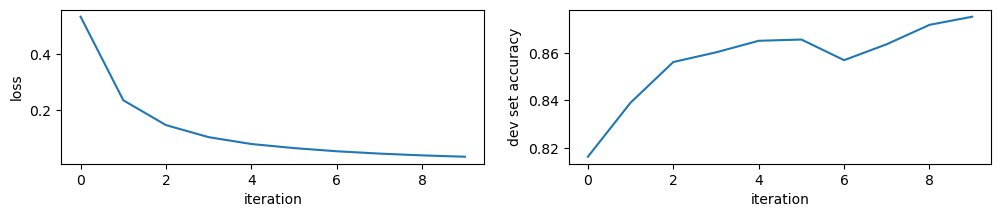

In [158]:
# Set hyperparameters and variables
vocab, word_to_ix = most_common.get_word_to_ix(EN_TRAIN_FILE, 6900)
X_tr, Y_tr = preproc.load_data(EN_TRAIN_FILE)
X_dv, Y_dv = preproc.load_data(EN_DEV_FILE)
X_te, Y_te = preproc.load_data(EN_TEST_FILE)

if START_TAG in all_tags:
    all_tags.remove(START_TAG)
if END_TAG in all_tags:
    all_tags.remove(END_TAG)
tag_to_ix = {}
for tag in all_tags:
    if tag not in tag_to_ix:
        tag_to_ix[tag] = len(tag_to_ix)

filename = 'data/polyglot-en.pkl'
word_embeddings = bilstm.obtain_polyglot_embeddings(filename, word_to_ix)
torch.manual_seed(711)
embedding_dim = 64
hidden_dim = 30
model = bilstm.BiGRU(len(word_to_ix), tag_to_ix, embedding_dim, hidden_dim, word_embeddings)

# Train on English corpus
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr, Y_tr, word_to_ix, tag_to_ix, 
                                        X_dv, Y_dv, num_its=10, status_frequency=1,
                                        optim_args = {'lr':0.1,'momentum':0.5}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model, 'bigru-dev-en.preds', word_to_ix)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bigru-train-en.preds', word_to_ix, all_tags, testfile=EN_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bigru-test-en.preds', word_to_ix, all_tags, testfile=EN_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Epoch 1: Dev Accuracy: 0.6709639613243481
Epoch 2: Dev Accuracy: 0.729197187225315
Epoch 3: Dev Accuracy: 0.7545414591268679
Epoch 4: Dev Accuracy: 0.7715353061822443
Epoch 5: Dev Accuracy: 0.7738792850864342
Epoch 6: Dev Accuracy: 0.7910928801640785
Epoch 7: Dev Accuracy: 0.7907998828010548
Epoch 8: Dev Accuracy: 0.7973190741283328
Epoch 9: Dev Accuracy: 0.8074274831526517
Epoch 10: Dev Accuracy: 0.7875036624670378
Accuracy:
 Dev:    0.7875036624670378 
 Train:  0.8255013821090396 
 Test:   0.7872164638726153


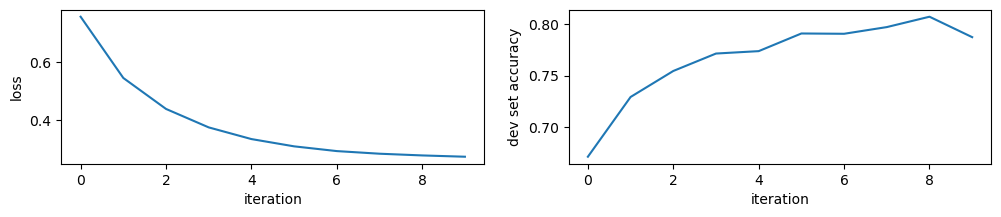

In [159]:
# Set hyperparameters and variables
vocab_gk, word_to_ix_gk = most_common.get_word_to_ix(GK_TRAIN_FILE, 6900)
X_tr_gk, Y_tr_gk = preproc.load_data(GK_TRAIN_FILE)
X_dv_gk, Y_dv_gk = preproc.load_data(GK_DEV_FILE)
X_te_gk, Y_te_gk = preproc.load_data(GK_TEST_FILE)

if START_TAG in all_tags_gk:
    all_tags_gk.remove(START_TAG)
if END_TAG in all_tags_gk:
    all_tags_gk.remove(END_TAG)
tag_to_ix_gk = {}
for tag in all_tags_gk:
    if tag not in tag_to_ix_gk:
        tag_to_ix_gk[tag] = len(tag_to_ix_gk)

torch.manual_seed(711)
embedding_dim = 64 #30
hidden_dim = 30
model = bilstm.BiGRU(len(word_to_ix_gk), tag_to_ix_gk, embedding_dim, hidden_dim)

# Train on Greek corpus
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr_gk, Y_tr_gk, word_to_ix_gk, tag_to_ix_gk, 
                                        X_dv_gk, Y_dv_gk, num_its=10, status_frequency=1,
                                        optim_args = {'lr':0.1,'momentum':0.5}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model, 'bigru-dev-gk.preds', word_to_ix_gk, trainfile=GK_TRAIN_FILE, testfile=GK_DEV_FILE)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bigru-train-gk.preds', word_to_ix_gk, all_tags_gk, trainfile=GK_TRAIN_FILE, testfile=GK_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bigru-test-gk.preds', word_to_ix_gk, all_tags_gk, trainfile=GK_TRAIN_FILE, testfile=GK_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Epoch 1: Dev Accuracy: 0.6592689295039165
Epoch 2: Dev Accuracy: 0.7038927130310942
Epoch 3: Dev Accuracy: 0.7272331671809479
Epoch 4: Dev Accuracy: 0.733088060764301
Epoch 5: Dev Accuracy: 0.7402088772845953
Epoch 6: Dev Accuracy: 0.741712160772213
Epoch 7: Dev Accuracy: 0.7476066144473456
Epoch 8: Dev Accuracy: 0.7507714217896986
Epoch 9: Dev Accuracy: 0.7513252630746103
Epoch 10: Dev Accuracy: 0.7533428277553604
Accuracy:
 Dev:    0.7533428277553604 
 Train:  0.7795348899968291 
 Test:   0.7438835225269689


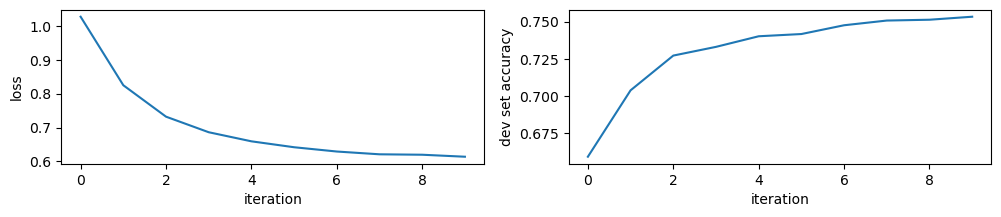

In [160]:
# Set hyperparameters and variables
vocab_kr, word_to_ix_kr = most_common.get_word_to_ix(KR_TRAIN_FILE, 6900)
X_tr_kr, Y_tr_kr = preproc.load_data(KR_TRAIN_FILE)
X_dv_kr, Y_dv_kr = preproc.load_data(KR_DEV_FILE)
X_te_kr, Y_te_kr = preproc.load_data(KR_TEST_FILE)

if START_TAG in all_tags_kr:
    all_tags_kr.remove(START_TAG)
if END_TAG in all_tags_kr:
    all_tags_kr.remove(END_TAG)
tag_to_ix_kr = {}
for tag in all_tags_kr:
    if tag not in tag_to_ix_kr:
        tag_to_ix_kr[tag] = len(tag_to_ix_kr)

torch.manual_seed(711)
embedding_dim = 64 #30
hidden_dim = 30
model = bilstm.BiGRU(len(word_to_ix_kr), tag_to_ix_kr, embedding_dim, hidden_dim)

# Train on Korean corpus
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr_kr, Y_tr_kr, word_to_ix_kr, tag_to_ix_kr, 
                                        X_dv_kr, Y_dv_kr, num_its=10, status_frequency=1,
                                        optim_args = {'lr':0.1,'momentum':0.5}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model, 'bigru-dev-kr.preds', word_to_ix_kr, trainfile=KR_TRAIN_FILE, testfile=KR_DEV_FILE)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bigru-train-kr.preds', word_to_ix_kr, all_tags_kr, trainfile=KR_TRAIN_FILE, testfile=KR_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bigru-test-kr.preds', word_to_ix_kr, all_tags_kr, trainfile=KR_TRAIN_FILE, testfile=KR_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Epoch 1: Dev Accuracy: 0.43128654970760233
Epoch 2: Dev Accuracy: 0.4722222222222222
Epoch 3: Dev Accuracy: 0.48830409356725146
Epoch 4: Dev Accuracy: 0.5175438596491229
Epoch 5: Dev Accuracy: 0.5394736842105263
Epoch 6: Dev Accuracy: 0.5526315789473685
Epoch 7: Dev Accuracy: 0.5847953216374269
Epoch 8: Dev Accuracy: 0.5833333333333334
Epoch 9: Dev Accuracy: 0.577485380116959
Epoch 10: Dev Accuracy: 0.577485380116959
Accuracy:
 Dev:    0.577485380116959 
 Train:  0.9968944099378882 
 Test:   0.6134751773049646


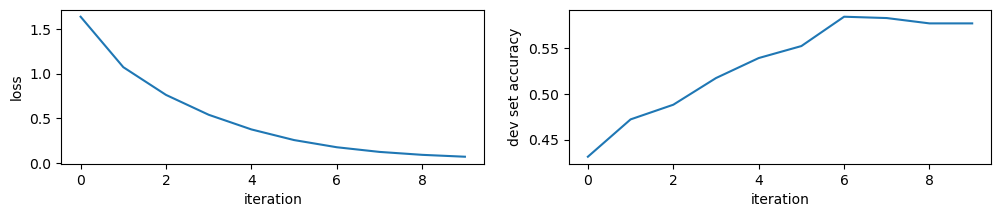

In [161]:
# Set hyperparameters and variables
vocab_sw, word_to_ix_sw = most_common.get_word_to_ix(SW_TRAIN_FILE, 6900)
X_tr_sw, Y_tr_sw = preproc.load_data(SW_TRAIN_FILE)
X_dv_sw, Y_dv_sw = preproc.load_data(SW_DEV_FILE)
X_te_sw, Y_te_sw = preproc.load_data(SW_TEST_FILE)

if START_TAG in all_tags_sw:
    all_tags_sw.remove(START_TAG)
if END_TAG in all_tags_sw:
    all_tags_sw.remove(END_TAG)
tag_to_ix_sw = {}
for tag in all_tags_sw:
    if tag not in tag_to_ix_sw:
        tag_to_ix_sw[tag] = len(tag_to_ix_sw)

torch.manual_seed(711)
embedding_dim = 64 #30
hidden_dim = 30
model = bilstm.BiGRU(len(word_to_ix_sw), tag_to_ix_sw, embedding_dim, hidden_dim)

# Train on SSL corpus
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr_sw, Y_tr_sw, word_to_ix_sw, tag_to_ix_sw, 
                                        X_dv_sw, Y_dv_sw, num_its=10, status_frequency=1,
                                        optim_args = {'lr':0.1,'momentum':0.5}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model, 'bigru-dev-sw.preds', word_to_ix_sw, trainfile=SW_TRAIN_FILE, testfile=SW_DEV_FILE)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bigru-train-sw.preds', word_to_ix_sw, all_tags_sw, trainfile=SW_TRAIN_FILE, testfile=SW_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bigru-test-sw.preds', word_to_ix_sw, all_tags_sw, trainfile=SW_TRAIN_FILE, testfile=SW_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

### BiLSTM Model Training

Epoch 1: Dev Accuracy: 0.8030842230130486
Epoch 2: Dev Accuracy: 0.819296164491894
Epoch 3: Dev Accuracy: 0.8165282720442862
Epoch 4: Dev Accuracy: 0.8430209568999605
Epoch 5: Dev Accuracy: 0.8432845657044945
Epoch 6: Dev Accuracy: 0.8403848688546197
Epoch 7: Dev Accuracy: 0.841439304072756
Epoch 8: Dev Accuracy: 0.8133649663898774
Epoch 9: Dev Accuracy: 0.8511928298405167
Epoch 10: Dev Accuracy: 0.866877553710294
Accuracy:
 Dev:    0.8655595096876235 
 Train:  0.9791970252751118 
 Test:   0.7696083292017848


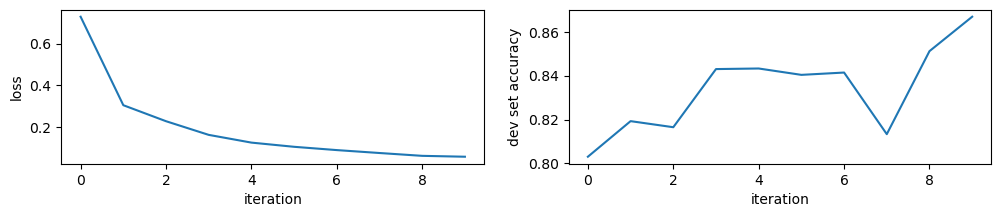

In [88]:
# Set hyperparameters and variables
vocab, word_to_ix = most_common.get_word_to_ix(EN_TRAIN_FILE, 6900)
X_tr, Y_tr = preproc.load_data(EN_TRAIN_FILE)
X_dv, Y_dv = preproc.load_data(EN_DEV_FILE)
X_te, Y_te = preproc.load_data(EN_TEST_FILE)

if START_TAG in all_tags:
    all_tags.remove(START_TAG)
if END_TAG in all_tags:
    all_tags.remove(END_TAG)
tag_to_ix = {}
for tag in all_tags:
    if tag not in tag_to_ix:
        tag_to_ix[tag] = len(tag_to_ix)

filename = 'data/polyglot-en.pkl'
word_embeddings = bilstm.obtain_polyglot_embeddings(filename, word_to_ix)
torch.manual_seed(711)
embedding_dim = 64
hidden_dim = 30
model = bilstm.BiLSTM(len(word_to_ix), tag_to_ix, embedding_dim, hidden_dim, word_embeddings)

# Train on English corpus
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr, Y_tr, word_to_ix, tag_to_ix, 
                                        X_dv, Y_dv, num_its=10, status_frequency=1,
                                        optim_args = {'lr':0.1,'momentum':0.5}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model, 'bilstm-dev-en.preds', word_to_ix)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm-train-en.preds', word_to_ix, all_tags, testfile=EN_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm-test-en.preds', word_to_ix, all_tags, testfile=EN_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Epoch 1: Dev Accuracy: 0.7498535013184882
Epoch 2: Dev Accuracy: 0.8075007324934076
Epoch 3: Dev Accuracy: 0.8250073249340756
Epoch 4: Dev Accuracy: 0.8515968356284793
Epoch 5: Dev Accuracy: 0.8671989452094931
Epoch 6: Dev Accuracy: 0.8225900966891297
Epoch 7: Dev Accuracy: 0.8701289188397304
Epoch 8: Dev Accuracy: 0.8765748608262526
Epoch 9: Dev Accuracy: 0.882654556108995
Epoch 10: Dev Accuracy: 0.882654556108995
Accuracy:
 Dev:    0.8829475534720187 
 Train:  0.9021349173675234 
 Test:   0.8850082619798708


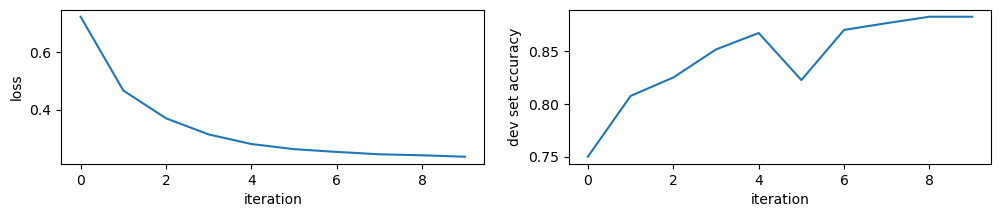

In [89]:
# Set hyperparameters and variables
vocab_gk, word_to_ix_gk = most_common.get_word_to_ix(GK_TRAIN_FILE, 6900)
X_tr_gk, Y_tr_gk = preproc.load_data(GK_TRAIN_FILE)
X_dv_gk, Y_dv_gk = preproc.load_data(GK_DEV_FILE)
X_te_gk, Y_te_gk = preproc.load_data(GK_TEST_FILE)

if START_TAG in all_tags_gk:
    all_tags_gk.remove(START_TAG)
if END_TAG in all_tags_gk:
    all_tags_gk.remove(END_TAG)
tag_to_ix_gk = {}
for tag in all_tags_gk:
    if tag not in tag_to_ix_gk:
        tag_to_ix_gk[tag] = len(tag_to_ix_gk)

torch.manual_seed(711)
embedding_dim = 64 #30
hidden_dim = 30
model = bilstm.BiLSTM(len(word_to_ix_gk), tag_to_ix_gk, embedding_dim, hidden_dim)

# Train on Greek corpus
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr_gk, Y_tr_gk, word_to_ix_gk, tag_to_ix_gk, 
                                        X_dv_gk, Y_dv_gk, num_its=10, status_frequency=1,
                                        optim_args = {'lr':0.1,'momentum':0.5}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model, 'bilstm-dev-gk.preds', word_to_ix_gk, trainfile=GK_TRAIN_FILE, testfile=GK_DEV_FILE)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm-train-gk.preds', word_to_ix_gk, all_tags_gk, trainfile=GK_TRAIN_FILE, testfile=GK_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm-test-gk.preds', word_to_ix_gk, all_tags_gk, trainfile=GK_TRAIN_FILE, testfile=GK_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Epoch 1: Dev Accuracy: 0.6961784951341087
Epoch 2: Dev Accuracy: 0.7371231901258011
Epoch 3: Dev Accuracy: 0.756468075005934
Epoch 4: Dev Accuracy: 0.7637075718015666
Epoch 5: Dev Accuracy: 0.7659624970329931
Epoch 6: Dev Accuracy: 0.7686921433657726
Epoch 7: Dev Accuracy: 0.7695624653849197
Epoch 8: Dev Accuracy: 0.7711053089643168
Epoch 9: Dev Accuracy: 0.771500909882111
Epoch 10: Dev Accuracy: 0.7734393543793021
Accuracy:
 Dev:    0.7736371548381992 
 Train:  0.8032491583627372 
 Test:   0.7650708594796587


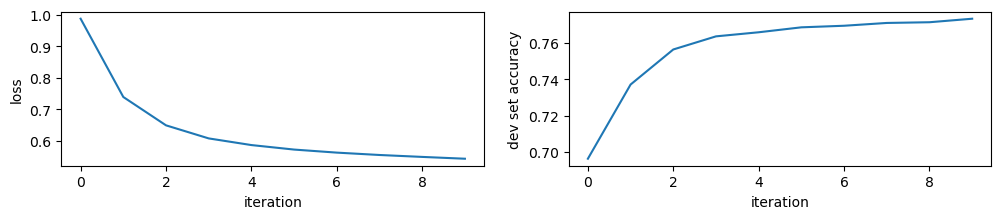

In [90]:
# Set hyperparameters and variables
vocab_kr, word_to_ix_kr = most_common.get_word_to_ix(KR_TRAIN_FILE, 6900)
X_tr_kr, Y_tr_kr = preproc.load_data(KR_TRAIN_FILE)
X_dv_kr, Y_dv_kr = preproc.load_data(KR_DEV_FILE)
X_te_kr, Y_te_kr = preproc.load_data(KR_TEST_FILE)

if START_TAG in all_tags_kr:
    all_tags_kr.remove(START_TAG)
if END_TAG in all_tags_kr:
    all_tags_kr.remove(END_TAG)
tag_to_ix_kr = {}
for tag in all_tags_kr:
    if tag not in tag_to_ix_kr:
        tag_to_ix_kr[tag] = len(tag_to_ix_kr)

torch.manual_seed(711)
embedding_dim = 64 #30
hidden_dim = 30
model = bilstm.BiLSTM(len(word_to_ix_kr), tag_to_ix_kr, embedding_dim, hidden_dim)

# Train on Korean corpus
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr_kr, Y_tr_kr, word_to_ix_kr, tag_to_ix_kr, 
                                        X_dv_kr, Y_dv_kr, num_its=10, status_frequency=1,
                                        optim_args = {'lr':0.1,'momentum':0.5}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model, 'bilstm-dev-kr.preds', word_to_ix_kr, trainfile=KR_TRAIN_FILE, testfile=KR_DEV_FILE)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm-train-kr.preds', word_to_ix_kr, all_tags_kr, trainfile=KR_TRAIN_FILE, testfile=KR_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm-test-kr.preds', word_to_ix_kr, all_tags_kr, trainfile=KR_TRAIN_FILE, testfile=KR_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Epoch 1: Dev Accuracy: 0.36988304093567254
Epoch 2: Dev Accuracy: 0.47076023391812866
Epoch 3: Dev Accuracy: 0.49707602339181284
Epoch 4: Dev Accuracy: 0.49853801169590645
Epoch 5: Dev Accuracy: 0.5087719298245614
Epoch 6: Dev Accuracy: 0.49853801169590645
Epoch 7: Dev Accuracy: 0.5307017543859649
Epoch 8: Dev Accuracy: 0.5394736842105263
Epoch 9: Dev Accuracy: 0.5482456140350878
Epoch 10: Dev Accuracy: 0.564327485380117
Accuracy:
 Dev:    0.5716374269005848 
 Train:  0.9301242236024845 
 Test:   0.6099290780141844


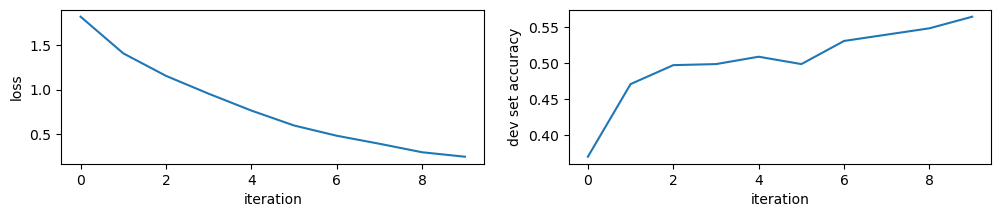

In [91]:
# Set hyperparameters and variables
vocab_sw, word_to_ix_sw = most_common.get_word_to_ix(SW_TRAIN_FILE, 6900)
X_tr_sw, Y_tr_sw = preproc.load_data(SW_TRAIN_FILE)
X_dv_sw, Y_dv_sw = preproc.load_data(SW_DEV_FILE)
X_te_sw, Y_te_sw = preproc.load_data(SW_TEST_FILE)

if START_TAG in all_tags_sw:
    all_tags_sw.remove(START_TAG)
if END_TAG in all_tags_sw:
    all_tags_sw.remove(END_TAG)
tag_to_ix_sw = {}
for tag in all_tags_sw:
    if tag not in tag_to_ix_sw:
        tag_to_ix_sw[tag] = len(tag_to_ix_sw)

torch.manual_seed(711)
embedding_dim = 64 #30
hidden_dim = 30
model = bilstm.BiLSTM(len(word_to_ix_sw), tag_to_ix_sw, embedding_dim, hidden_dim)

# Train on SSL corpus
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr_sw, Y_tr_sw, word_to_ix_sw, tag_to_ix_sw, 
                                        X_dv_sw, Y_dv_sw, num_its=10, status_frequency=1,
                                        optim_args = {'lr':0.1,'momentum':0.5}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model, 'bilstm-dev-sw.preds', word_to_ix_sw, trainfile=SW_TRAIN_FILE, testfile=SW_DEV_FILE)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm-train-sw.preds', word_to_ix_sw, all_tags_sw, trainfile=SW_TRAIN_FILE, testfile=SW_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm-test-sw.preds', word_to_ix_sw, all_tags_sw, trainfile=SW_TRAIN_FILE, testfile=SW_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

### BiLSTM-CRF Model Training

Epoch 1: Dev Accuracy: 0.7096349018057203
Epoch 3: Dev Accuracy: 0.7678924476077501
Epoch 5: Dev Accuracy: 0.8040068538289179
Epoch 7: Dev Accuracy: 0.8153420324238829
Epoch 9: Dev Accuracy: 0.8216686437327007
Accuracy:
 Dev:    0.8187689468828259 
 Train:  0.9720617054419376 
 Test:   0.7298463063956371


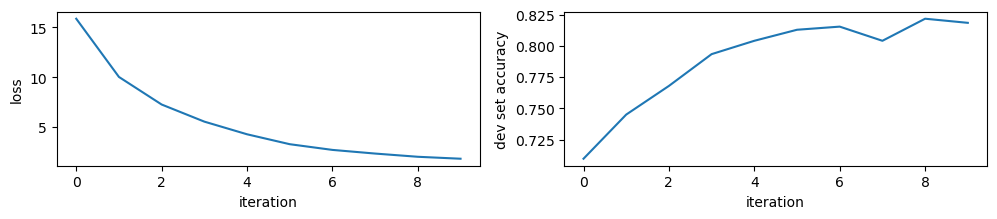

In [182]:
# Set hyperparameters and variables
if START_TAG not in all_tags:
    all_tags.append(START_TAG)
if END_TAG not in all_tags:
    all_tags.append(END_TAG)
all_tags = sorted(all_tags)
if START_TAG not in tag_to_ix:
    tag_to_ix[START_TAG] = len(tag_to_ix)
if END_TAG not in tag_to_ix:
    tag_to_ix[END_TAG] = len(tag_to_ix)
torch.manual_seed(711);
embedding_dim = 30
hidden_dim = 30
model = bilstm.BiLSTM_CRF(len(word_to_ix), tag_to_ix, embedding_dim, hidden_dim)

# Train on English corpus
loss = model.neg_log_likelihood
model, losses, accuracies = bilstm.train_model(loss, model, X_tr, Y_tr, word_to_ix, tag_to_ix,
                                               X_dv, Y_dv, 
                                               num_its=10, status_frequency=2,
                                               optim_args = {'lr':0.1,'momentum':0}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model,'bilstm_crf-dev-en.preds', word_to_ix)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm_crf-train-en.preds', word_to_ix, all_tags, testfile=EN_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm_crf-test-en.preds', word_to_ix, all_tags, testfile=EN_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Epoch 1: Dev Accuracy: 0.8044975095224143
Epoch 3: Dev Accuracy: 0.8581892762965133
Epoch 5: Dev Accuracy: 0.8639027248754761
Epoch 7: Dev Accuracy: 0.8715939056548491
Epoch 9: Dev Accuracy: 0.8756226193964254
Accuracy:
 Dev:    0.8944090080360151 
 Train:  0.894473167836692 
 Test:   0.8766711732011416


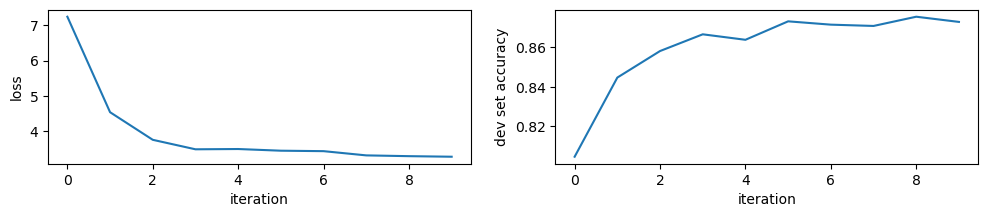

In [184]:
# Set hyperparameters and variables
if START_TAG not in all_tags_gk:
    all_tags_gk.append(START_TAG)
if END_TAG not in all_tags_gk:
    all_tags_gk.append(END_TAG)
all_tags_gk = sorted(all_tags_gk)
if START_TAG not in tag_to_ix_gk:
    tag_to_ix_gk[START_TAG] = len(tag_to_ix_gk)
if END_TAG not in tag_to_ix_gk:
    tag_to_ix_gk[END_TAG] = len(tag_to_ix_gk)
torch.manual_seed(711);
embedding_dim = 30
hidden_dim = 30
model = bilstm.BiLSTM_CRF(len(word_to_ix_gk), tag_to_ix_gk, embedding_dim, hidden_dim)

# Train on Greek corpus
loss = model.neg_log_likelihood
model, losses, accuracies = bilstm.train_model(loss, model, X_tr_gk, Y_tr_gk, word_to_ix_gk, tag_to_ix_gk,
                                               X_dv_gk, Y_dv_gk, 
                                               num_its=10, status_frequency=2,
                                               optim_args = {'lr':0.1,'momentum':0}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model,'bilstm_crf-dev-gk.preds', word_to_ix_gk, trainfile=GK_TRAIN_FILE, testfile=GK_TRAIN_FILE)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm_crf-train-gk.preds', word_to_ix_gk, all_tags_gk, trainfile=GK_TRAIN_FILE, testfile=GK_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm_crf-test-gk.preds', word_to_ix_gk, all_tags_gk, trainfile=GK_TRAIN_FILE, testfile=GK_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Epoch 1: Dev Accuracy: 0.7303188543397421
Epoch 3: Dev Accuracy: 0.7368462694833452
Epoch 5: Dev Accuracy: 0.7509296621568162
Epoch 7: Dev Accuracy: 0.7486351768336102
Epoch 9: Dev Accuracy: 0.7537384286731545
Accuracy:
 Dev:    0.771877508888634 
 Train:  0.7718201628627136 
 Test:   0.7385955016569132


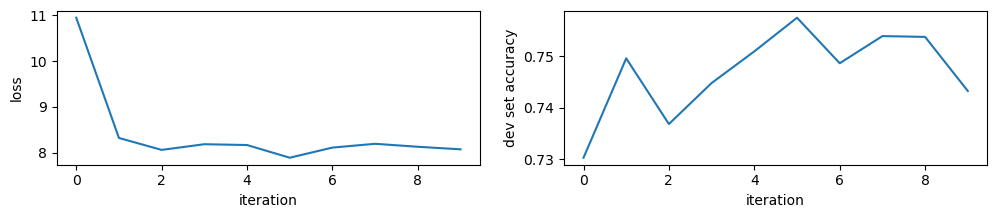

In [185]:
# Set hyperparameters and variables
if START_TAG not in all_tags_kr:
    all_tags_kr.append(START_TAG)
if END_TAG not in all_tags_kr:
    all_tags_kr.append(END_TAG)
all_tags_kr = sorted(all_tags_kr)
if START_TAG not in tag_to_ix_kr:
    tag_to_ix_kr[START_TAG] = len(tag_to_ix_kr)
if END_TAG not in tag_to_ix_kr:
    tag_to_ix_kr[END_TAG] = len(tag_to_ix_kr)
torch.manual_seed(711);
embedding_dim = 30
hidden_dim = 30
model = bilstm.BiLSTM_CRF(len(word_to_ix_kr), tag_to_ix_kr, embedding_dim, hidden_dim)

# Train on Korean corpus
loss = model.neg_log_likelihood
model, losses, accuracies = bilstm.train_model(loss, model, X_tr_kr, Y_tr_kr, word_to_ix_kr, tag_to_ix_kr,
                                               X_dv_kr, Y_dv_kr, 
                                               num_its=10, status_frequency=2,
                                               optim_args = {'lr':0.1,'momentum':0}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model,'bilstm_crf-dev-kr.preds', word_to_ix_kr, trainfile=KR_TRAIN_FILE, testfile=KR_TRAIN_FILE)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm_crf-train-kr.preds', word_to_ix_kr, all_tags_kr, trainfile=KR_TRAIN_FILE, testfile=KR_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm_crf-test-kr.preds', word_to_ix_kr, all_tags_kr, trainfile=KR_TRAIN_FILE, testfile=KR_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)

Epoch 1: Dev Accuracy: 0.4283625730994152
Epoch 3: Dev Accuracy: 0.5043859649122807
Epoch 5: Dev Accuracy: 0.5862573099415205
Epoch 7: Dev Accuracy: 0.6081871345029239
Epoch 9: Dev Accuracy: 0.618421052631579
Accuracy:
 Dev:    0.9953416149068323 
 Train:  0.9922360248447205 
 Test:   0.7340425531914894


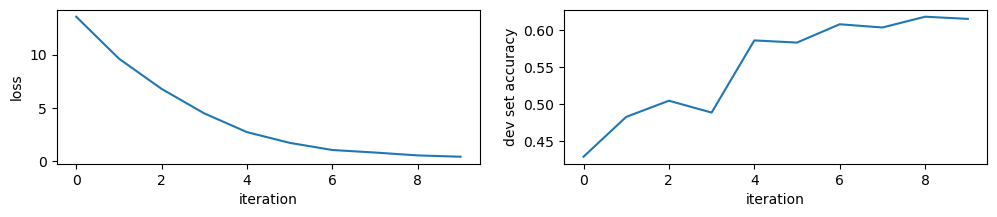

In [186]:
# Set hyperparameters and variables
if START_TAG not in all_tags_sw:
    all_tags_sw.append(START_TAG)
if END_TAG not in all_tags_sw:
    all_tags_sw.append(END_TAG)
all_tags_sw = sorted(all_tags_sw)
if START_TAG not in tag_to_ix_sw:
    tag_to_ix_sw[START_TAG] = len(tag_to_ix_sw)
if END_TAG not in tag_to_ix_sw:
    tag_to_ix_sw[END_TAG] = len(tag_to_ix_sw)
torch.manual_seed(711);
embedding_dim = 30
hidden_dim = 30
model = bilstm.BiLSTM_CRF(len(word_to_ix_sw), tag_to_ix_sw, embedding_dim, hidden_dim)

# Train on SSL corpus
loss = model.neg_log_likelihood
model, losses, accuracies = bilstm.train_model(loss, model, X_tr_sw, Y_tr_sw, word_to_ix_sw, tag_to_ix_sw,
                                               X_dv_sw, Y_dv_sw, 
                                               num_its=10, status_frequency=2,
                                               optim_args = {'lr':0.1,'momentum':0}, param_file = 'best.params')
bilstm.plot_results(losses, accuracies)

# Test the model
confusion = tagger_base.eval_model(model,'bilstm_crf-dev-sw.preds', word_to_ix_sw, trainfile=SW_TRAIN_FILE, testfile=SW_TRAIN_FILE)
dev_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm_crf-train-sw.preds', word_to_ix_sw, all_tags_sw, trainfile=SW_TRAIN_FILE, testfile=SW_TRAIN_FILE)
train_acc = scorer.accuracy(confusion)
confusion = tagger_base.eval_model(model, 'bilstm_crf-test-sw.preds', word_to_ix_sw, all_tags_sw, trainfile=SW_TRAIN_FILE, testfile=SW_TEST_FILE)
test_acc = scorer.accuracy(confusion)
print("Accuracy:\n Dev:   ", dev_acc, "\n Train: ", train_acc, "\n Test:  ", test_acc)